In [5]:
import numpy as np

from utils import GraphEdgeIterator, GraphCycleIterator, iteration_logging
from tqdm.auto import tqdm
import io
import pandas as pd

In [6]:

OMEGA = 10
BUFFER_COUNT = 2
PRUNE_INTERVAL = 1_000

_TOTAL_EDGES = 2_912_276

In [7]:

csv_stream = io.StringIO()

wrapped_edges = GraphCycleIterator(
    tqdm(  # type: ignore
        iteration_logging(
            GraphEdgeIterator(buffer_count=BUFFER_COUNT),
            log_stream=csv_stream,
        ),
        total=_TOTAL_EDGES,
        desc="Edges",
    ),
    omega=OMEGA,
    prune_interval=PRUNE_INTERVAL
)

wrapped_edges.run()



Edges:   0%|          | 0/2912276 [00:00<?, ?it/s]

EmptyDataError: No columns to parse from file

array([<Axes: xlabel='time_seconds'>, <Axes: xlabel='time_seconds'>,
       <Axes: xlabel='time_seconds'>], dtype=object)

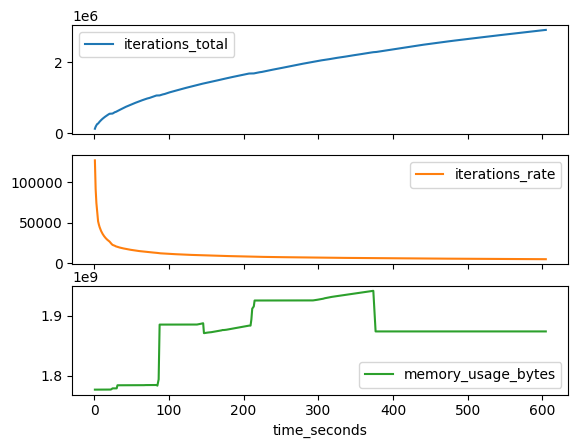

In [8]:
csv_stream.seek(0)
df = pd.read_csv(csv_stream)
df = df.set_index("time_seconds")
df.plot(subplots=True)

In [10]:
for u, intervals in wrapped_edges.seed_intervals.items():
    for interval in intervals:
        print(interval)


Interval(8319539, 8319541)
Interval(8323561, 8323563)
Interval(8324892, 8324894)
Interval(8324952, 8324958)
Interval(8325026, 8325034)
Interval(8325028, 8325034)
Interval(8325029, 8325034)
Interval(8325930, 8325933)
Interval(8326950, 8326954)
Interval(8327817, 8327825)
Interval(8328771, 8328774)
Interval(8331095, 8331104)
Interval(8331095, 8331098)
Interval(8331097, 8331104)
Interval(8331116, 8331125)
Interval(8331133, 8331136)
Interval(8331166, 8331168)
Interval(8331240, 8331246)
Interval(8320347, 8320349)
Interval(8321708, 8321716)
Interval(8323594, 8323598)
Interval(8327298, 8327304)
Interval(8327660, 8327669)
Interval(8327842, 8327848)
Interval(8328974, 8328983)
Interval(8329150, 8329157)
Interval(8330686, 8330694)
Interval(8348107, 8348114)
Interval(8348838, 8348843)
Interval(8349012, 8349021)
Interval(8349466, 8349475)
Interval(8321106, 8321115)
Interval(8322751, 8322759)
Interval(8322757, 8322759)
Interval(8323650, 8323658)
Interval(8329545, 8329551)
Interval(8331442, 8331449)
I

In [ ]:
def combine_seeds(C, w):
    """
    Combine seed_intervals for a root node s using the window length w.
    Each element in C is a tuple of the form (s, (ts, te), cycle_info).
    
    :param C: List of seed_intervals [ (s, (ts, te), cycle_info), ... ]
    :param w: Window length (integer or float)
    :return: A list of combined candidates of the form:
             (s, (ts, tmax), tn, combined_cycle_info)
    """
    
    # 1) Sort C by (ts ascending) and (te descending)
    #    i.e. for the same ts, place larger te first.
    C.sort(key=lambda x: (x[1][0], -x[1][1]))
    
    combined = []
    
    # 2) While there are seed_intervals remaining
    while C:
        # 3) Let (s, [ts, te], cycle_info) be the first in C
        first_s, (first_ts, first_te), first_cycle_info = C[0]
        
        # 4) Find the maximal prefix of C satisfying t'e < ts + w
        limit = first_ts + w
        prefix = []
        
        # We'll collect prefix seed_intervals from the front of C while they are "compatible"
        i = 0
        while i < len(C):
            s_i, (ts_i, te_i), cyc_i = C[i]
            if te_i < limit:
                prefix.append(C[i])
                i += 1
            else:
                break
        
        # Remove that prefix from C
        C = C[i:]
        
        # 5) Determine tn
        if not C:
            # If C is empty, tn = first_ts + w
            tn = limit
        else:
            # Else take the ts' from the new first seed in C
            _, (ts_next, _), _ = C[0]
            tn = ts_next
        
        # 6) Calculate tmax = max of all te in prefix
        tmax = max(seed[1][1] for seed in prefix)
        
        # 7) Combine cycle info from prefix
        #    If you need a set-union, ensure each cycle_info is a set; otherwise adapt as needed.
        combined_cycle_info = set()
        for _, (_, _), cyc_i in prefix:
            if isinstance(cyc_i, set):
                combined_cycle_info.update(cyc_i)
            else:
                # If cyc_i is not a set, you could collect them in a set
                combined_cycle_info.add(cyc_i)
        
        # 8) Output a combined tuple
        combined.append((first_s, (first_ts, tmax), tn, combined_cycle_info))
    
    return combined